In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
prices = pd.read_csv('factors/usa/close_price.csv', index_col=0, parse_dates=True)
prices = prices.replace(0, np.nan)

In [4]:
universe = pqr.Universe(prices)
universe.filter(prices > 10)

factorizer = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.PctChange(12),
    pqr.Hold(12)
)
momentum = factorizer(prices, better="more")
momentum.values = momentum.values.replace(0, np.nan)  # костыль, т.к. в данных есть проблемы

benchmark = pqr.Benchmark.from_universe(universe)

# Строим time-series факторную модель

In [5]:
builder = pqr.PortfolioBuilder(
    pqr.EqualWeights(),
    pqr.TheoreticalAllocation()
)

fm = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.TimeSeries(min_threshold=0),
        pqr.fm.TimeSeries(max_threshold=-0)
    ],
    portfolio_builder=builder
)

portfolios = fm(momentum, universe)

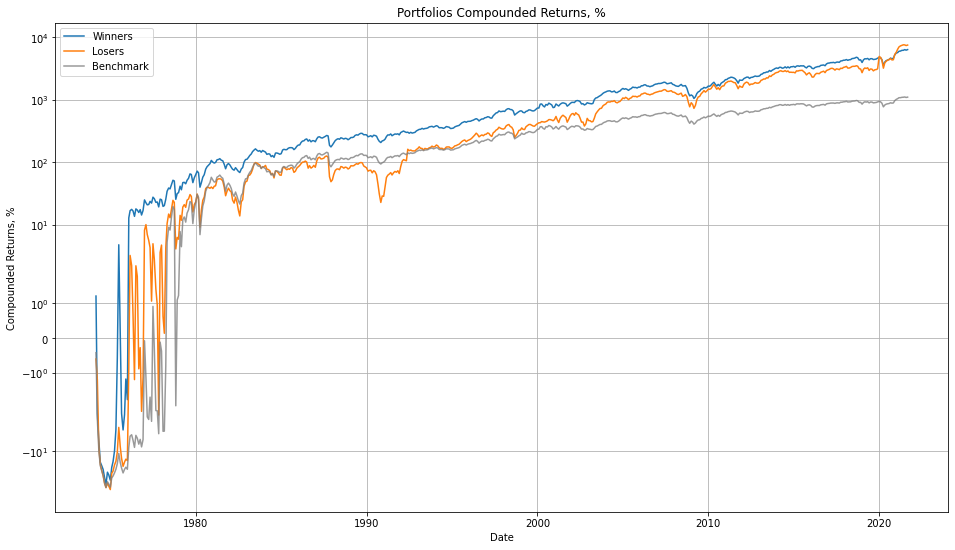

,Winners,Losers
"Total Return, %",6355.56,7508.19
"CAGR, %",9.15,9.53
"Mean Return, %",9.89*** (4.62),11.29*** (3.68)
"Volatility, %",14.78,21.16
"Win Rate, %",62.70,57.44
"Mean Turnover, %",116.50,143.15
"Maximum Drawdown, %",-42.86,-46.68
"Value at Risk, %",-19.30,-27.07
"Expected Tail Loss, %",-33.35,-41.93
"Expected Tail Reward, %",34.11,53.87


In [6]:
summary = pqr.dash.SummaryDashboard(benchmark, log_scale=True)
summary(portfolios)

# Строим quantile факторную модель с 5 квантилями

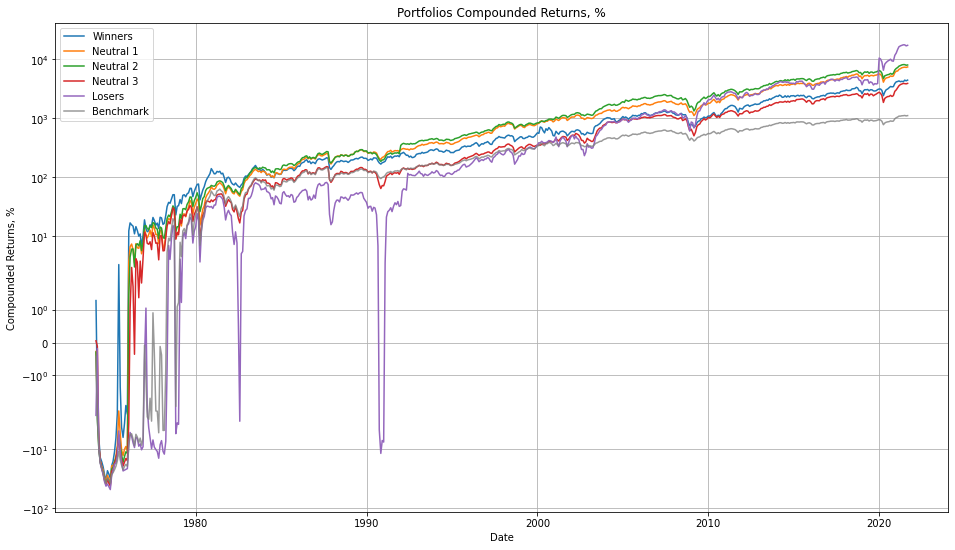

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
"Total Return, %",4415.44,7388.56,7970.47,3882.79,17189.27
"CAGR, %",8.34,9.49,9.67,8.05,11.44
"Mean Return, %",9.52*** (3.81),10.17*** (4.81),10.38*** (4.76),9.14*** (3.80),15.26*** (3.06)
"Volatility, %",17.26,14.58,15.04,16.58,34.38
"Win Rate, %",59.02,63.75,62.17,62.00,57.27
"Mean Turnover, %",164.61,162.82,161.58,164.41,157.33
"Maximum Drawdown, %",-44.11,-42.15,-45.55,-51.93,-52.57
"Value at Risk, %",-23.91,-18.43,-19.88,-23.80,-33.48
"Expected Tail Loss, %",-37.75,-32.31,-32.10,-36.97,-50.37
"Expected Tail Reward, %",41.08,32.70,36.16,39.75,84.82


In [7]:
fmq = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.Quantiles(0, 0.2),
        pqr.fm.Quantiles(0.2, 0.4),
        pqr.fm.Quantiles(0.4, 0.6),
        pqr.fm.Quantiles(0.6, 0.8),
        pqr.fm.Quantiles(0.8, 1),
    ],
    portfolio_builder=builder,
)

portfolios_q = fmq(momentum, universe)

summary(portfolios_q)

# Пробуем prophet_test

Дисклеймер: тут что-то забаговало, буду разбираться

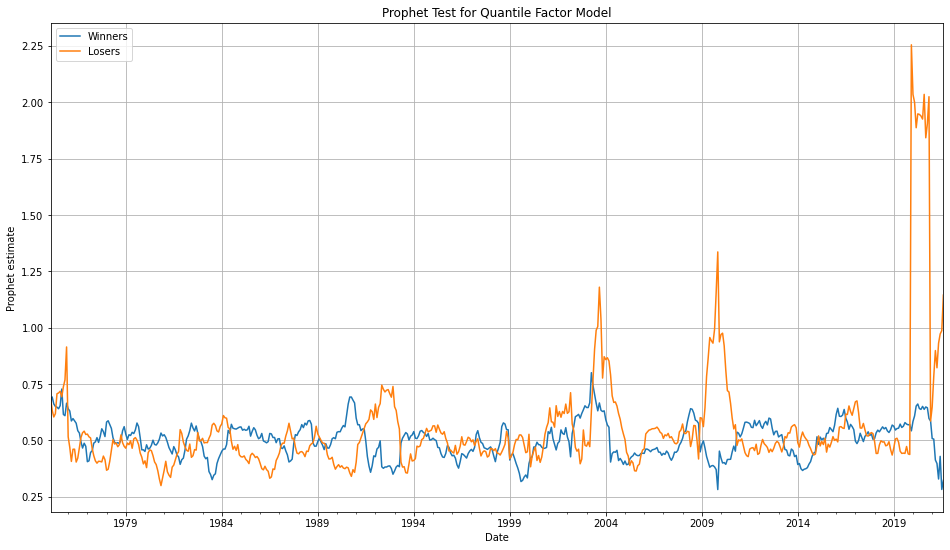

In [8]:
prophet = pqr.tests.ProphetTest(
    universe,
    builder,
    pqr.metrics.TrailingMeanReturn()
)

prophet(portfolios_q[0]).plot(label=portfolios_q[0].name)
prophet(portfolios_q[-1]).plot(label=portfolios_q[-1].name)

plt.title("Prophet Test for Quantile Factor Model")
plt.xlabel("Date")
plt.ylabel("Prophet estimate")
plt.legend()
plt.grid();

# Double time-series momentum

Сначала строим 2 простых лонг-портфеля. Первый покупает акции, когда индекс растет, второй - **покупает**, когда индекс падает. Потом из них соберем аля-wml, и готово.

In [9]:
_, benchmark_returns = pqr.utils.align(momentum.values, benchmark.returns)
double_ts_longs = pqr.fm.TimeSeries(min_threshold=0)(momentum) & (benchmark_returns > 0)[:, np.newaxis]
double_ts_shorts = pqr.fm.TimeSeries(max_threshold=0)(momentum) & (benchmark_returns < 0)[:, np.newaxis]

double_ts_portfolio = builder(
    universe,
    longs=double_ts_longs,
    shorts=double_ts_shorts,
    name="Double TS"
)

/tmp/ipykernel_31002/1505756477.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  double_ts_longs = pqr.fm.TimeSeries(min_threshold=0)(momentum) & (benchmark_returns > 0)[:, np.newaxis]
/tmp/ipykernel_31002/1505756477.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  double_ts_shorts = pqr.fm.TimeSeries(max_threshold=0)(momentum) & (benchmark_returns < 0)[:, np.newaxis]


<AxesSubplot:xlabel='Double TS'>

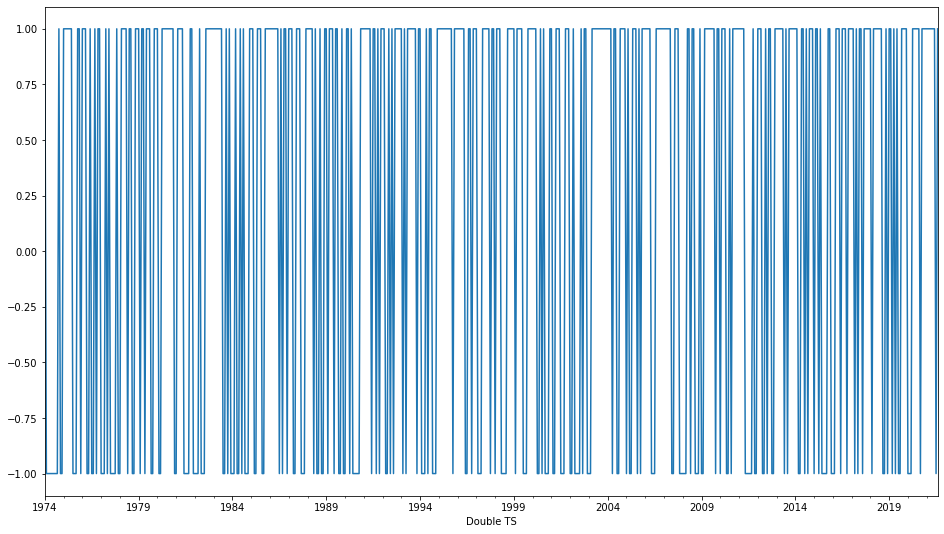

In [10]:
double_ts_portfolio.weights.sum(axis=1).plot()

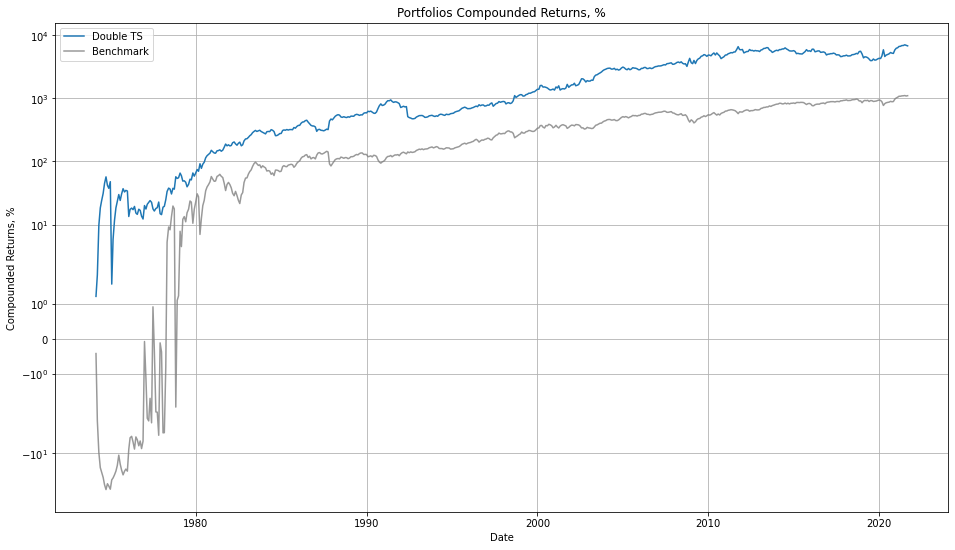

,Double TS
"Total Return, %",6799.35
"CAGR, %",9.31
"Mean Return, %",10.53*** (4.10)
"Volatility, %",17.73
"Win Rate, %",62.00
"Mean Turnover, %",1067.93
"Maximum Drawdown, %",-45.07
"Value at Risk, %",-22.89
"Expected Tail Loss, %",-40.08
"Expected Tail Reward, %",43.30


In [11]:
summary([double_ts_portfolio])

Использование методики double time-series momentum действительно показало себя лучше простого моментума за счет тайминга, но есть подозрение, что с введением ограничения на шорты и комиссий, это уйдет, и получится либо такой же моментум, либо даже чуть хуже.